# Parking with Hindsight Experience Replay

### In This Notebook we will experiment wiht the parameter n_sampled_goal 4 -> 8
* **Understanding n_sampled_goal:** 
n_sampled_goal is a parameter used in HER (Hindsight Experience Replay) to specify the number of future states to be sampled as additional goals for replay.
When an episode is stored in the replay buffer, HER can use hindsight to treat any achieved state as a desired goal state. The n_sampled_goal parameter controls how many of these future states (goals) are sampled for replay.

* **Implications of Changing n_sampled_goal:**
Increasing n_sampled_goal from 4 to 8 means that during each episode, more future states will be sampled as additional goals for replay.
With a higher n_sampled_goal, the replay buffer will contain a larger variety of experiences, where each experience is replayed with different potential goals. This can potentially lead to a more diverse and robust learning process.
More sampled goals can provide the agent with richer experiences during replay, which may help in learning to achieve different states or goals, ultimately improving the learning efficiency and performance.
However, increasing n_sampled_goal also comes with a cost of increased computation and memory usage, as more goals need to be sampled and stored during training.

##  Warming up
We start with a few useful installs and imports:

In [1]:
#@title Install environment and agent
!pip install highway-env
# TODO: we use the bleeding edge version because the current stable version does not support the latest gym>=0.21 versions. Revert back to stable at the next SB3 release.
!pip install git+https://github.com/DLR-RM/stable-baselines3

# Environment
import gymnasium as gym
import highway_env

# Agent
from stable_baselines3 import HerReplayBuffer, SAC

2024-04-26 22:30:20.271906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Matplotlib created a temporary cache directory at /tmp/matplotlib-wdhm9kmg because the default path (/home/nostalgic_ramanujan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
#@title Import helpers for visualization of episodes
import sys
from tqdm.notebook import trange
!pip install tensorboardx gym pyvirtualdisplay
!apt-get install -y xvfb ffmpeg
!git clone https://github.com/Farama-Foundation/HighwayEnv.git 2> /dev/null
sys.path.insert(0, '/content/HighwayEnv/scripts/')
from utils import record_videos, show_videos

In [3]:
#@title Tensorboard - click the refresh button once training is running

%reload_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5384), started 0:26:00 ago. (Use '!kill 5384' to kill it.)

In [4]:
#@title Training
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

LEARNING_STEPS = 5e4 # @param {type: "number"}

env = gym.make("parking-v0", render_mode="rgb_array")
config = {
    "observation": {
        "type": "KinematicsGoal",
        "features": ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
        "scales": [100, 100, 5, 5, 1, 1],
        "normalize": False
    },
    "action": {
        "type": "ContinuousAction"
    },
    "simulation_frequency": 15,
    "policy_frequency": 5,
    "screen_width": 600,
    "screen_height": 300,
    "centering_position": [0.5, 0.5],
    "scaling": 7,
    "show_trajectories": True,
    "render_agent": True,
    "offscreen_rendering": False
}


env.unwrapped.configure(config)
her_kwargs = dict(n_sampled_goal=8, goal_selection_strategy='future')
model = SAC('MultiInputPolicy', env, replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=her_kwargs, verbose=1, 
            tensorboard_log="logs", 
            buffer_size=int(1e6),
            learning_rate = 1e-3,  
            gamma=0.95, batch_size=1024, tau=0.05, 

            policy_kwargs=dict(net_arch=[512, 512, 512]))

model.learn(int(LEARNING_STEPS))
# Save the trained model
model.save("parking_agent6")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/SAC_16
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 95.2     |
|    ep_rew_mean     | -47.7    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 4        |
|    fps             | 23       |
|    time_elapsed    | 16       |
|    total_timesteps | 381      |
| train/             |          |
|    actor_loss      | -7.8     |
|    critic_loss     | 0.206    |
|    ent_coef        | 0.757    |
|    ent_coef_loss   | -0.918   |
|    learning_rate   | 0.001    |
|    n_updates       | 280      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 81.5     |
|    ep_rew_mean     | -38.9    |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 8        |
|    fps             | 21       

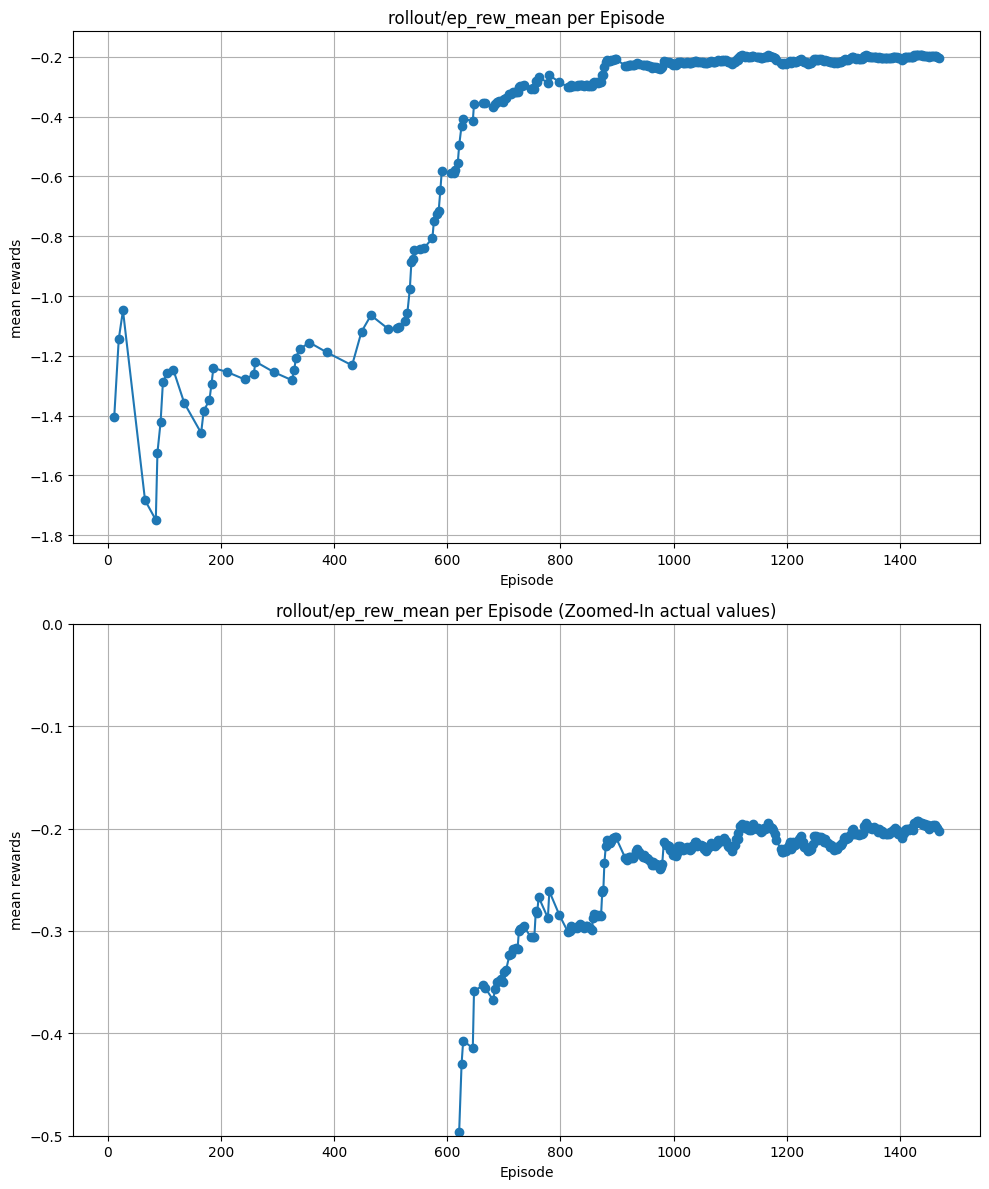

In [3]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

log_dir = "logs/SAC_16"
event_file_name = "events.out.tfevents.1714170664.e7c5f58cd75a.7177.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/ep_rew_mean'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot) 

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step / 34 for event in scalar_events]
    episode_values = [event.value / 34 for event in scalar_events]

    # Create subplots with two axes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

    # Plot the full-size figure
    ax1.plot(episode_steps, episode_values, marker='o', linestyle='-')
    ax1.set_title(f'{tag_to_plot} per Episode')
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('mean rewards')
    ax1.grid(True)

    # Zoomed-in plot on y-axis
    ax2.plot(episode_steps, episode_values, marker='o', linestyle='-')
    ax2.set_title(f'{tag_to_plot} per Episode (Zoomed-In actual values)')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('mean rewards')
    ax2.grid(True)
    ax2.set_ylim(-0.5, 0)  # Set y-axis limit for zoomed-in plot

    # Adjust layout and display plots
    plt.tight_layout()
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


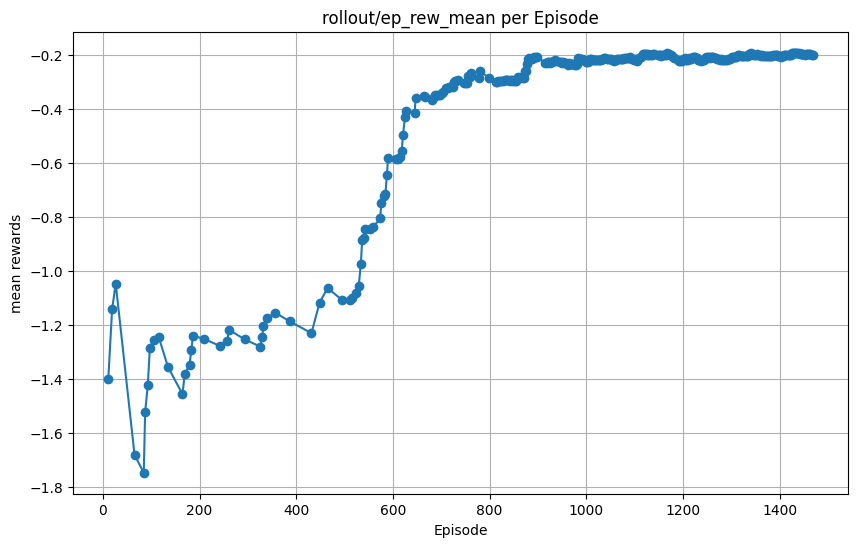

In [30]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_16"
event_file_name = "events.out.tfevents.1714170664.e7c5f58cd75a.7177.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/ep_rew_mean'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot) 

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/34 for event in scalar_events]
    episode_values = [event.value/34 for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('mean rewards')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


Matplotlib created a temporary cache directory at /tmp/matplotlib-3_vctdnv because the default path (/home/nostalgic_ramanujan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-04-27 11:15:47.543105: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


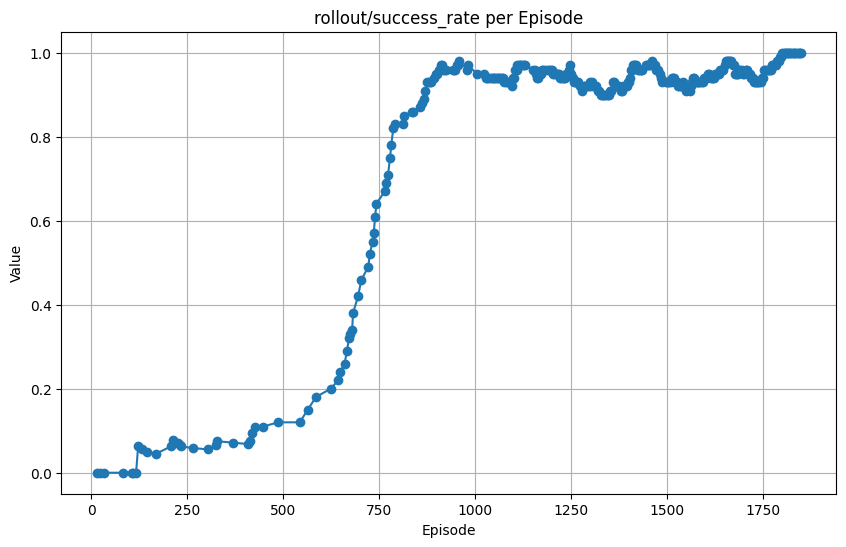

In [2]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_16"
event_file_name = "events.out.tfevents.1714170664.e7c5f58cd75a.7177.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/success_rate'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/27 for event in scalar_events]
    episode_values = [event.value for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


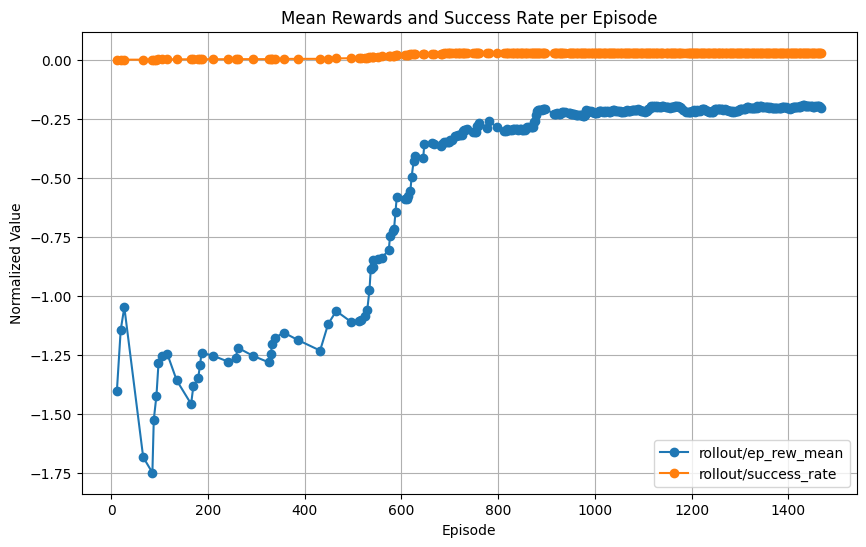

In [29]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_16"
event_file_name = "events.out.tfevents.1714170664.e7c5f58cd75a.7177.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tags for the scalar values to plot
tags_to_plot = ['rollout/ep_rew_mean', 'rollout/success_rate']

# Check if the specified tags exist in the event file
tags = event_acc.Tags()

# Check if all specified tags are found in the event file
if all(tag in tags['scalars'] for tag in tags_to_plot):
    plt.figure(figsize=(10, 6))

    for tag_to_plot in tags_to_plot:
        # Extract scalar events for the specified tag
        scalar_events = event_acc.Scalars(tag_to_plot)

        # Extract episode steps and values for the specified tag
        episode_steps = [event.step / 34 for event in scalar_events]
        episode_values = [event.value / 34 for event in scalar_events]

        # Plot the scalar value per episode
        plt.plot(episode_steps, episode_values, marker='o', linestyle='-', label=tag_to_plot)

    plt.title('Mean Rewards and Success Rate per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    missing_tags = [tag for tag in tags_to_plot if tag not in tags['scalars']]
    print(f"Tags '{', '.join(missing_tags)}' not found in the event file.")


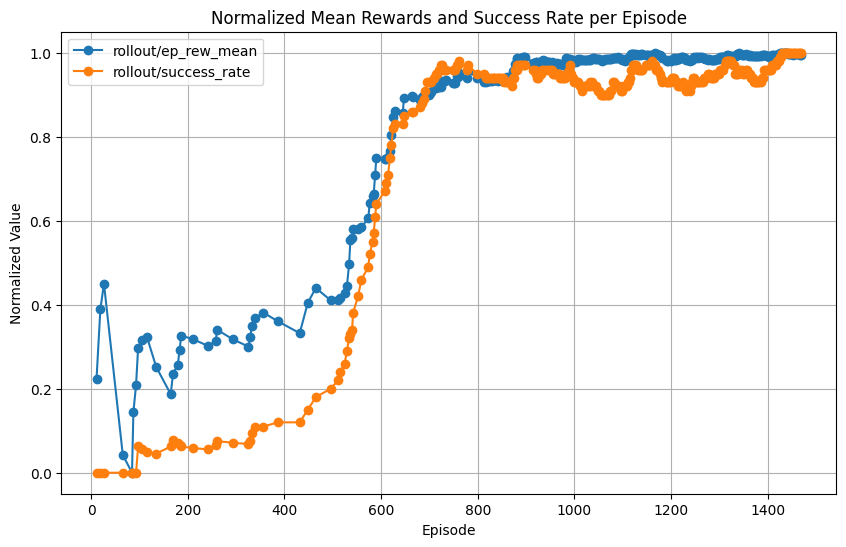

In [27]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

# Construct the absolute path to the event file
log_dir = "logs/SAC_16"
event_file_name = "events.out.tfevents.1714170664.e7c5f58cd75a.7177.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tags for the scalar values to plot
tags_to_plot = ['rollout/ep_rew_mean', 'rollout/success_rate']

# Check if the specified tags exist in the event file
tags = event_acc.Tags()

# Check if all specified tags are found in the event file
if all(tag in tags['scalars'] for tag in tags_to_plot):
    plt.figure(figsize=(10, 6))

    for tag_to_plot in tags_to_plot:
        # Extract scalar events for the specified tag
        scalar_events = event_acc.Scalars(tag_to_plot)

        # Extract episode steps and values for the specified tag
        episode_steps = [event.step / 34 for event in scalar_events]
        episode_values = [event.value / 34 for event in scalar_events]

        # Normalize values between 0 and 1
        normalized_values = (episode_values - np.min(episode_values)) / (np.max(episode_values) - np.min(episode_values))

        # Plot the normalized scalar value per episode
        plt.plot(episode_steps, normalized_values, marker='o', linestyle='-', label=tag_to_plot)

    plt.title('Normalized Mean Rewards and Success Rate per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    missing_tags = [tag for tag in tags_to_plot if tag not in tags['scalars']]
    print(f"Tags '{', '.join(missing_tags)}' not found in the event file.")


 #### the increased n_sampled_goal accelerates learning and contributes to a smoother convergence of the training process. We can see improvements in sample efficiency and overall training time.

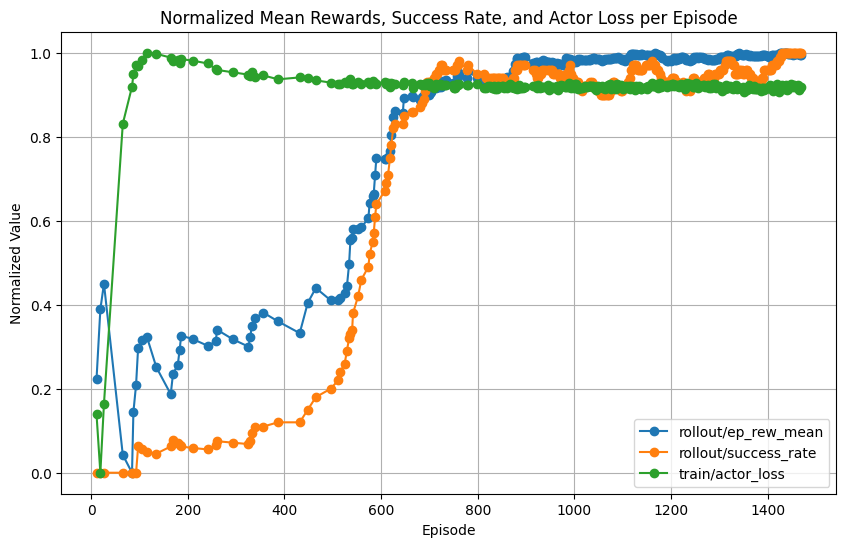

In [28]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np

# Construct the absolute path to the event file
log_dir = "logs/SAC_16"
event_file_name = "events.out.tfevents.1714170664.e7c5f58cd75a.7177.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tags for the scalar values to plot
tags_to_plot = ['rollout/ep_rew_mean', 'rollout/success_rate', 'train/actor_loss']

# Check if the specified tags exist in the event file
tags = event_acc.Tags()

# Check if all specified tags are found in the event file
if all(tag in tags['scalars'] for tag in tags_to_plot):
    plt.figure(figsize=(10, 6))

    for tag_to_plot in tags_to_plot:
        # Extract scalar events for the specified tag
        scalar_events = event_acc.Scalars(tag_to_plot)

        # Extract episode steps and values for the specified tag
        episode_steps = [event.step / 34 for event in scalar_events]
        episode_values = [event.value / 34 if 'rollout' in tag_to_plot else event.value for event in scalar_events]

        # Normalize values between 0 and 1
        normalized_values = (episode_values - np.min(episode_values)) / (np.max(episode_values) - np.min(episode_values))

        # Plot the normalized scalar value per episode
        plt.plot(episode_steps, normalized_values, marker='o', linestyle='-', label=tag_to_plot)

    plt.title('Normalized Mean Rewards, Success Rate, and Actor Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Normalized Value')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    missing_tags = [tag for tag in tags_to_plot if tag not in tags['scalars']]
    print(f"Tags '{', '.join(missing_tags)}' not found in the event file.")


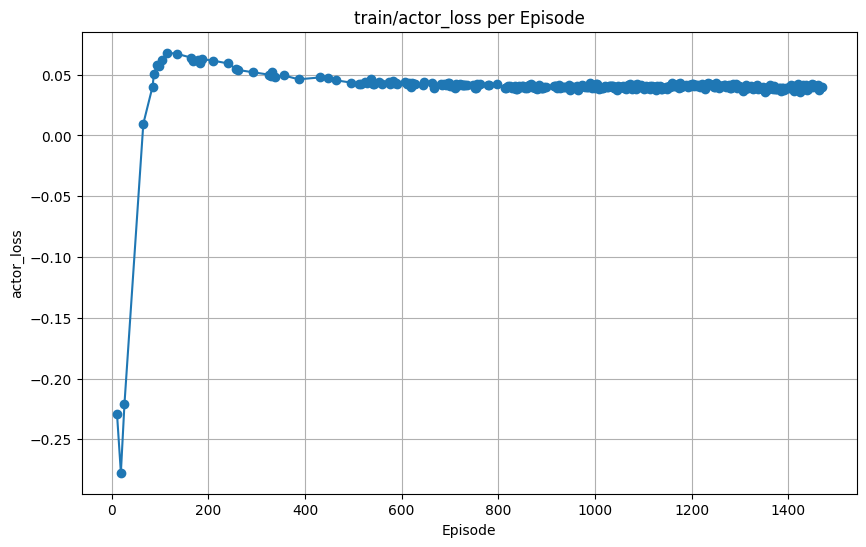

In [18]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_16"
event_file_name = "events.out.tfevents.1714170664.e7c5f58cd75a.7177.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'train/actor_loss'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/34 for event in scalar_events]
    episode_values = [event.value/34 for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('actor_loss')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


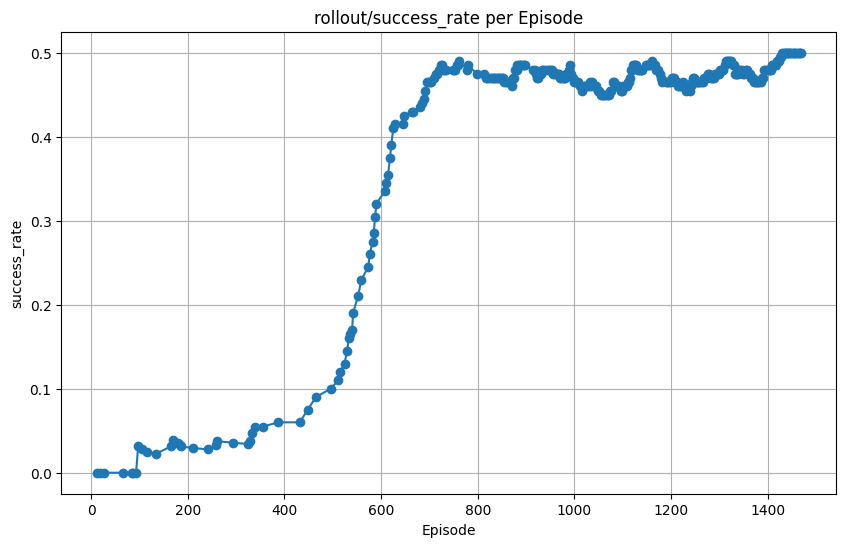

In [17]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Construct the absolute path to the event file
log_dir = "logs/SAC_16"
event_file_name = "events.out.tfevents.1714170664.e7c5f58cd75a.7177.0"
log_path = os.path.join(log_dir, event_file_name)

# Create an EventAccumulator
event_acc = EventAccumulator(log_path)
event_acc.Reload()

# Specify the tag for the scalar value to plot (e.g., 'train/actor_loss')
tag_to_plot = 'rollout/success_rate'

# Check if the specified tag exists in the event file
tags = event_acc.Tags()
if tag_to_plot in tags['scalars']:
    # Extract scalar events for the specified tag
    scalar_events = event_acc.Scalars(tag_to_plot)

    # Extract episode steps and values for the specified tag
    episode_steps = [event.step/34 for event in scalar_events]
    episode_values = [event.value/2 for event in scalar_events]

    # Plot the scalar value per episode
    plt.figure(figsize=(10, 6))
    plt.plot(episode_steps, episode_values, marker='o', linestyle='-')
    plt.title(f'{tag_to_plot} per Episode')
    plt.xlabel('Episode')
    plt.ylabel('success_rate')
    plt.grid(True)
    plt.show()
else:
    print(f"Tag '{tag_to_plot}' not found in the event file.")


In [ ]:
!pip install --upgrade jupyter
!pip install --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip install --upgrade tqdm


In [5]:
#@title Visualize a few episodes

N_EPISODES = 12  # @param {type: "integer"}

env = gym.make('parking-v0', render_mode='rgb_array')
env = record_videos(env)
for episode in trange(N_EPISODES, desc="Test episodes"):
    obs, info = env.reset()
    done = truncated = False
    while not (done or truncated):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, info = env.step(action)
env.close()
show_videos()

Test episodes:   0%|          | 0/12 [00:00<?, ?it/s]

Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4




t:  80%|████████  | 40/50 [00:00<00:00, 198.27it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-0.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4




t:  88%|████████▊ | 57/65 [00:00<00:00, 154.54it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-1.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4




t: 100%|██████████| 65/65 [00:00<00:00, 178.16it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-2.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4




t:  78%|███████▊  | 58/74 [00:00<00:00, 159.74it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-3.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4




t:  87%|████████▋ | 59/68 [00:00<00:00, 160.39it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-4.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4




t:  97%|█████████▋| 94/97 [00:00<00:00, 161.92it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-5.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4




t:  79%|███████▉  | 42/53 [00:00<00:00, 185.30it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-6.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4




t:  88%|████████▊ | 60/68 [00:00<00:00, 161.55it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-7.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4




t:  75%|███████▍  | 53/71 [00:00<00:00, 148.18it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-8.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4




t:  68%|██████▊   | 40/59 [00:00<00:00, 190.27it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-9.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4




t:  90%|█████████ | 72/80 [00:00<00:00, 163.85it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-10.mp4
Moviepy - Building video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4




t:  90%|████████▉ | 53/59 [00:00<00:00, 154.29it/s, now=None]
                                                             

Moviepy - Done !
Moviepy - video ready /home/nostalgic_ramanujan/workdir/HighwayEnv/scripts/videos/rl-video-episode-11.mp4


## pip install moviepy